# Making an accurate detector for fake disaster data

## Data loading and preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load csv data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Retrieve text
#train_text = train[['id', 'text']]
#test_text = test[['id', 'text']]
train_text = train[['text', 'target']]
test_text = test['text']

Overview text review

In [2]:
train_text

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [3]:
test_text

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

#### Text length analysis

In [4]:
# Compute text length
train_text['length'] = train_text['text'].str.len()

/home/nico/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


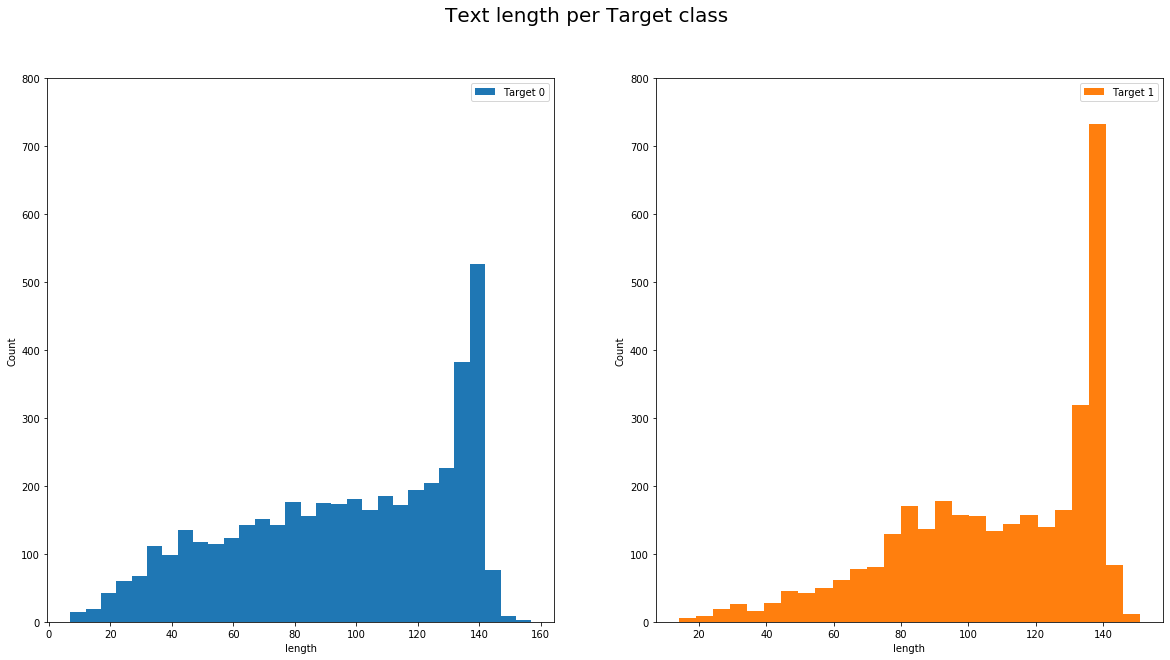

In [45]:
# Plot length analysis
fig, axes = plt.subplots(1, 2, figsize=(20,10))
colors=('tab:blue', 'tab:orange')

for (target, text), ax, col in zip(train_text.groupby('target'), axes, colors):
    ax.hist(text['length'], label='Target {}'.format(target),
           bins=(text['length'].max() - text['length'].min())//5,
           color= col)
    ax.set_xlabel('length')
    ax.set_ylabel('Count')
    ax.set_ylim((0, 800))
    ax.legend()

fig.suptitle('Text length per Target class', fontsize=20)
plt.plot();

###### Word count analysis

In [6]:
#Count number of words
train_text['words_count'] = train_text['text'].str.split().apply(lambda x: len(x))

/home/nico/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


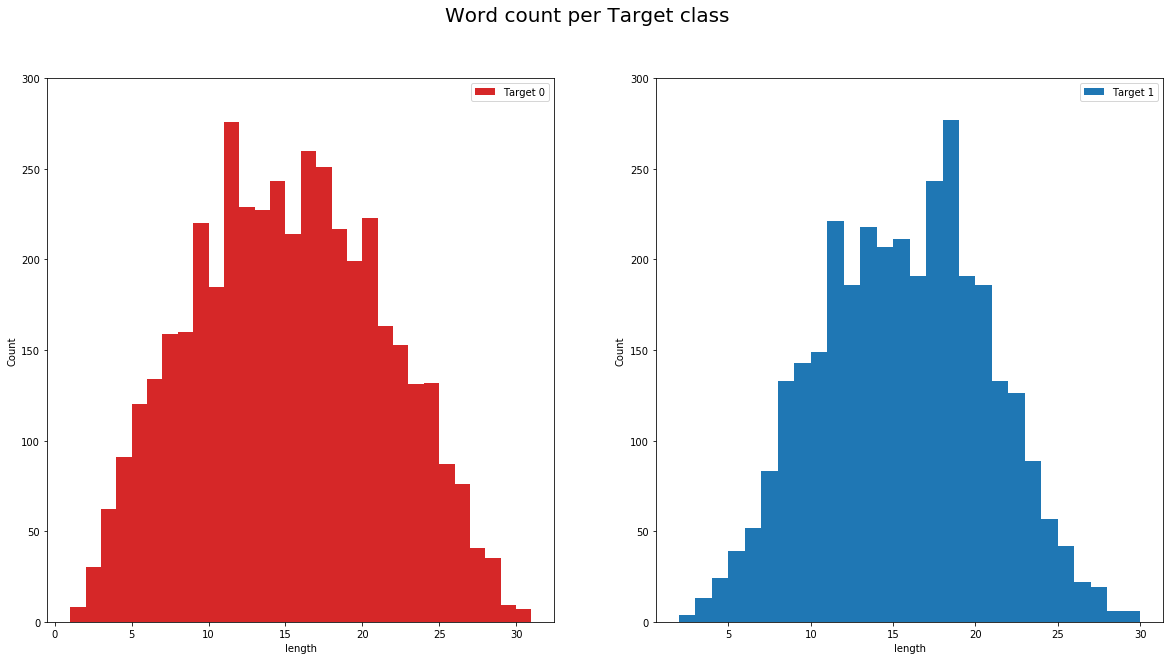

In [7]:
# Plot words analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
n_bins = lambda x, length: (x.max() - x.min())//length

# Target 0
axes[0].hist(train_text.loc[train_text['target'] == 0,'words_count'], label='Target 0',
            color='tab:red', bins=n_bins(train_text.loc[train_text['target'] == 0,'words_count'], 1))
axes[0].set_xlabel('length')
axes[0].set_ylabel('Count')
axes[0].set_ylim((0, 300))
axes[0].legend()

# Target 1
axes[1].hist(train_text.loc[train_text['target'] == 1,'words_count'], label='Target 1',
            color='tab:blue', bins=n_bins(train_text.loc[train_text['target'] == 1,'words_count'], 1))
axes[1].set_xlabel('length')
axes[1].set_ylabel('Count')
axes[1].set_ylim((0, 300))
axes[1].legend()

fig.suptitle('Word count per Target class', fontsize=20)
plt.plot();

There is no significative differente between distributions among the two targets. On a visual review, it is checked that both distributions closes to a Gaussian distribution.

### Text cleaning

In [8]:
import string
import re

1. Convert to lower.

In [9]:
train_text['text_proc'] = train_text['text'].str.lower()

2. Replace web url and number terms with tokens

In [10]:
# Replace URL by token TweburlT
url_replacer = re.compile(r'\bhttps?:\/\/[^ ]+\b')
train_text['text_proc'] = train_text['text_proc'].apply(lambda x: url_replacer.sub(' TweburlT ', x))

In [11]:
# Replace year by TyearT
year_replacer = re.compile(r'\b(?:19\d{2}|2\d{3})\b')
train_text['text_proc'] = train_text['text_proc'].apply(lambda x: year_replacer.sub(' TyearT ', x))

In [12]:
# Replace hours by ThourT
hour_replacer = re.compile(r'\b\d{2}:\d{2}(?::\d{2}(?:[,.:]\d+)?)?\b')
train_text['text_proc'] = train_text['text_proc'].apply(lambda x: hour_replacer.sub(' ThourT ', x))

In [13]:
# Replace numbers by TnumberT
num_replacer = re.compile(r'\b\d+([.,]\d+)?\b')
train_text['text_proc'] = train_text['text_proc'].apply(lambda x: num_replacer.sub(' TnumberT ', x))

In [14]:
# Replace emojis by TemojiT
emoji_replacer = re.compile("["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "]+")
train_text['text_proc'] = train_text['text_proc'].apply(lambda x: emoji_replacer.sub(' TemojiT ', x))

3. Remove punctuation symbols

In [15]:
remove_punctuation = lambda text: text.translate(text.maketrans('', '', string.punctuation))
train_text['text_proc'] = train_text['text_proc'].apply(remove_punctuation)

In [16]:
train_text['text_proc']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        TnumberT  people receive wildfires evacuation...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610    m1 TnumberT   ThourT  utc5km s of volcano hawa...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text_proc, Length: 7613, dtype: object

4. Let's proceed with word tokenization

In [19]:
import nltk

In [20]:
train_text['text_proc_token'] = train_text['text_proc'].apply(nltk.word_tokenize)

In [24]:
train_text['text_proc_token']

0       [our, deeds, are, the, reason, of, this, earth...
1           [forest, fire, near, la, ronge, sask, canada]
2       [all, residents, asked, to, shelter, in, place...
3       [TnumberT, people, receive, wildfires, evacuat...
4       [just, got, sent, this, photo, from, ruby, ala...
                              ...                        
7608    [two, giant, cranes, holding, a, bridge, colla...
7609    [ariaahrary, thetawniest, the, out, of, contro...
7610    [m1, TnumberT, ThourT, utc5km, s, of, volcano,...
7611    [police, investigating, after, an, ebike, coll...
7612    [the, latest, more, homes, razed, by, northern...
Name: text_proc_token, Length: 7613, dtype: object

Let's count the number of unique words

In [33]:
from functools import reduce

In [43]:
def word_frequency_map_reduce(pd_series):
    
    # Map: Count word frequence on each row
    word_count_row = map(nltk.FreqDist, pd_series)
    
    # Reduce: aggregate each word row count count in one global count
    word_freq = reduce(nltk.FreqDist.__add__, word_count_row)
    
    return word_freq

def word_frequency(pd_series):
    word_freq = {}
    
    for rec in pd_series:
        for word in rec:
            if word not in word_freq:
                word_freq[word] = 1
            else:
                word_freq[word] += 1
    
    return word_freq

In [48]:
word_freq1 = pd.Series(word_frequency(train_text['text_proc_token']))
print('Number of word tokens: ', len(word_freq1))

Number of word tokens:  17565


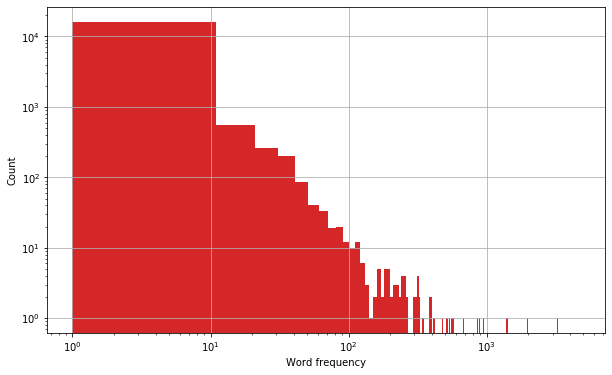

In [74]:
# Plot word frequency fistribution
word_freq1.hist(bins=(word_freq1.max() - word_freq1.min())//10, figsize=(10,6), color='tab:red')
plt.xlabel('Word frequency')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.show()

From the above bar plot, it's possible to check there is a high percentage of words which appears with low frequency (less than 10 repetitions in the whole dataset). Thus, they could be removed
Let's remove non-significative terms from the word set

5. Remove stopwords

In [63]:
eng_stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(record):
    return [word for word in record if word not in eng_stopwords]

In [66]:
train_text['text_proc_token'] = train_text['text_proc_token'].apply(remove_stopwords)

In [67]:
train_text['text_proc_token']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [TnumberT, people, receive, wildfires, evacuat...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610    [m1, TnumberT, ThourT, utc5km, volcano, hawaii...
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text_proc_token, Length: 7613, dtype: object

6. Reduce word to lexic root through **Stemming**

In [69]:
porter = nltk.PorterStemmer()
stem_text = lambda record: [porter.stem(word) for word in record]

In [70]:
train_text['text_proc_token'] = train_text['text_proc_token'].apply(stem_text)

In [71]:
train_text['text_proc_token']

0       [deed, reason, earthquak, may, allah, forgiv, us]
1            [forest, fire, near, la, rong, sask, canada]
2       [resid, ask, shelter, place, notifi, offic, ev...
3       [tnumbert, peopl, receiv, wildfir, evacu, orde...
4       [got, sent, photo, rubi, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, crane, hold, bridg, collaps, near...
7609    [ariaahrari, thetawniest, control, wild, fire,...
7610    [m1, tnumbert, thourt, utc5km, volcano, hawaii...
7611    [polic, investig, ebik, collid, car, littl, po...
7612    [latest, home, raze, northern, california, wil...
Name: text_proc_token, Length: 7613, dtype: object

Review word frequency distribution

In [72]:
word_freq2 = pd.Series(word_frequency(train_text['text_proc_token']))
print('Number of word tokens: ', len(word_freq2))

Number of word tokens:  14425


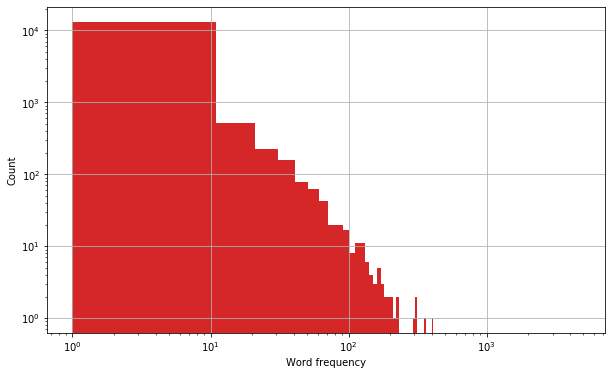

In [75]:
# Plot word frequency fistribution
word_freq2.hist(bins=(word_freq2.max() - word_freq2.min())//10, figsize=(10,6), color='tab:red')
plt.xlabel('Word frequency')
plt.ylabel('Count')
plt.yscale('log')
plt.xscale('log')
plt.show()

Plot words appearing less than 10 times

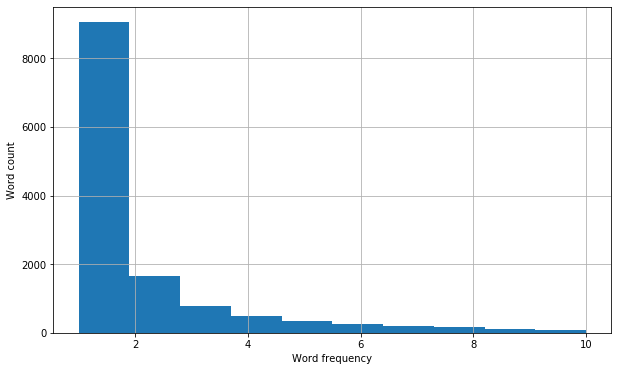

In [96]:
less_freq_words = word_freq2[word_freq2 <= 10]
less_freq_words.hist(bins=10, figsize=(10,6))
plt.xlabel('Word frequency')
plt.ylabel('Word count')
plt.show()

Show the 100 words with the highest frequency 

In [78]:
highest_freq_word = word_freq2.sort_values(ascending=False)

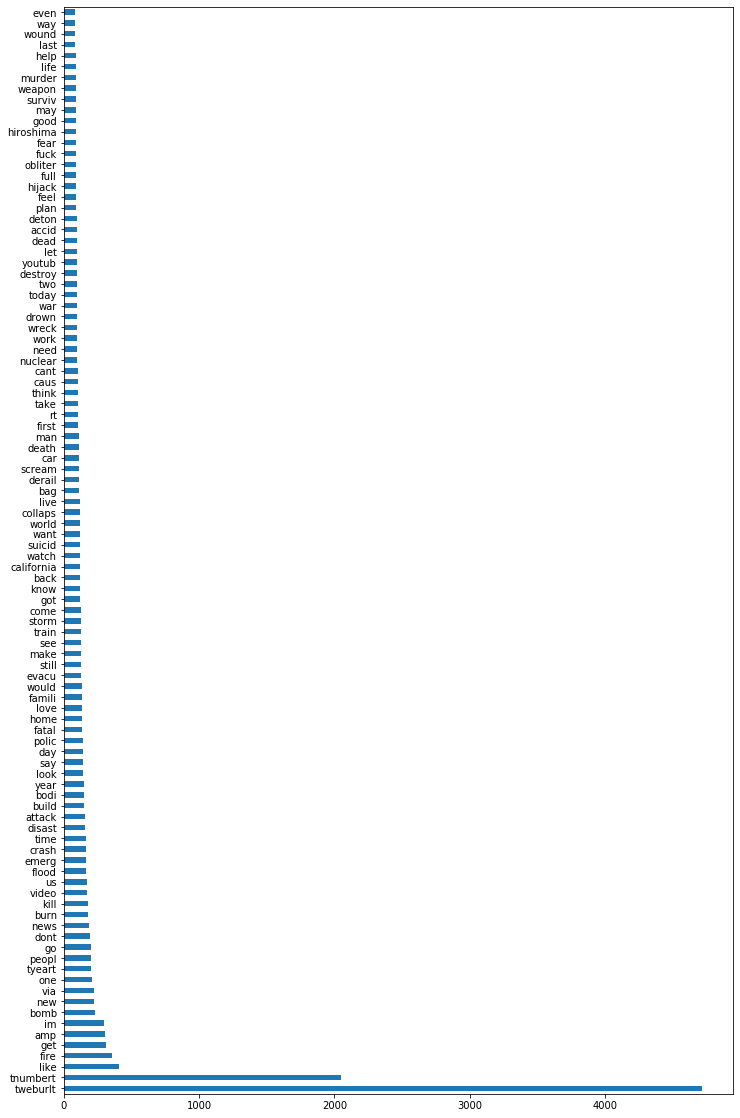

In [85]:
highest_freq_word[:100].plot.barh(figsize=(12,20))